In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

In [ ]:
%cd "drive/My Drive/CZ4032 (Local)"
!ls

In [ ]:
!pip install pyLDAvis

In [ ]:
import re
import pickle 
import pyLDAvis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from pyLDAvis import sklearn as sklearn_lda
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [ ]:
reviews_df = pd.read_csv('./yelp_review.csv')
reviews_df = reviews_df.drop(reviews_df.columns[0], axis=1)
print(reviews_df.shape)

reviews_df_trunc = reviews_df.head(10000)
print(reviews_df_trunc.shape)

(1778047, 9)
(10000, 9)


### Pre-processing

- Drop unrequired columns
- Remove punctation
- Lowercase texts

In [ ]:
# Drop unrequired columns
try:
    reviews_df_trunc = reviews_df_trunc.drop('date', axis=1)
except Exception:
    print('Date column already removed')
try:
    reviews_df_trunc = reviews_df_trunc.drop('user_id', axis=1)
except Exception:
    print("User ID column already removed")

# Remove punctuation
reviews_df_trunc['text_processed'] = reviews_df_trunc['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert reviews to lowercase
reviews_df_trunc['text_processed'] = reviews_df_trunc['text_processed'].map(lambda x: x.lower())

reviews_df_trunc.head()

,review_id,business_id,stars,useful,funny,cool,text,text_processed
0,i6g_oA9Yf9Y31qt0wibXpw,5JxlZaqCnk1MnbgRirs40Q,1.0,0.0,0.0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...","dismal lukewarm defrosted-tasting ""texmex"" glo..."
1,bVTjZgRNq8ToxzvtiVrqMA,d4qwVw4PcN-_2mK2o1Ro1g,1.0,0.0,0.0,0.0,10pm on a super bowl Sunday and they're alread...,10pm on a super bowl sunday and they're alread...
2,TeX0eOIeZb_wpo86rCedXQ,d4qwVw4PcN-_2mK2o1Ro1g,5.0,0.0,0.0,0.0,Holy heck this place is amazing. I love their ...,holy heck this place is amazing i love their c...
3,XvLG7ReC8JZmBltOLJzfcA,XZbuPXdyA0ZtTu3AzqtQhg,4.0,0.0,1.0,0.0,"As the previous person posted, what more can r...",as the previous person posted what more can re...
4,WGbtqQMeJwTVg6DFb156EQ,PL3cimEUfNHlenOGSOAdJg,4.0,3.0,0.0,1.0,"This was our choice, by default, for New Year'...",this was our choice by default for new year's ...


### Exploratory Analysis

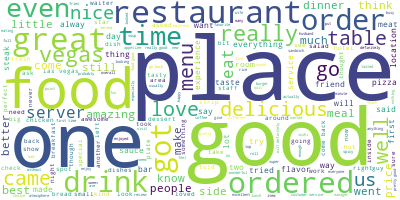

In [ ]:
long_string = ','.join(list(reviews_df_trunc['text_processed'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### Prepare text for LDA

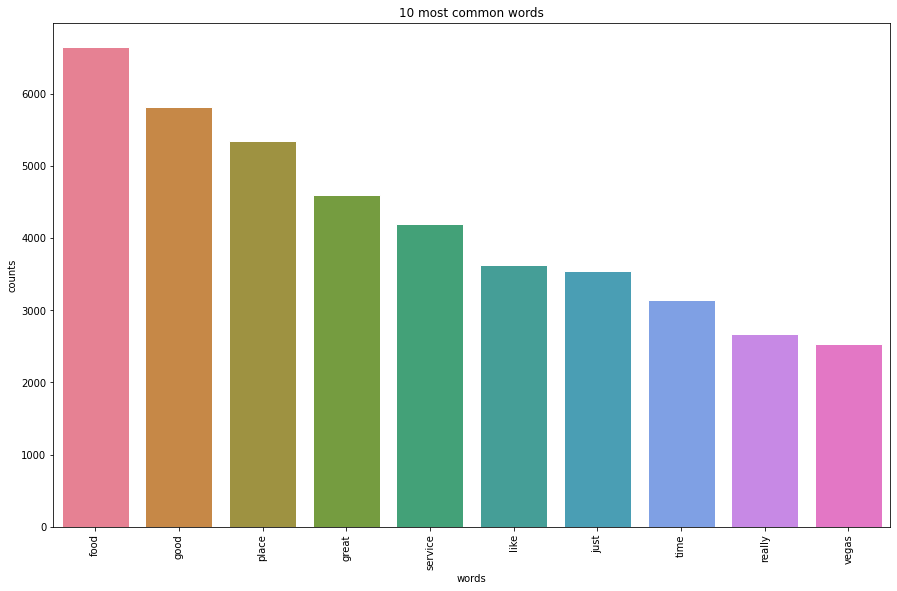

In [ ]:
def plot_top_common_words(count_data, count_vectorizer, top=10):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]

    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_style('whitegrid')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')

# Fit and transform the processed texts
doc_term_matrix = count_vect.fit_transform(reviews_df_trunc['text_processed'])
                                           
plot_top_common_words(doc_term_matrix, count_vect)

### Train LDA Model

In [ ]:
def print_topics(model, count_vectorizer, n_top_words=10):
    words = count_vectorizer.get_feature_names()
    for idx, topic in enumerate(model.components_):
        print(f"Topic #{idx}:")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1: -1]]))

In [ ]:
search_params = {
    'n_components': [3, 4, 5, 6, 7],
    'learning_decay': [0.5, 0.7, 0.9]
}


num_topics = 5
num_words = 10

LDA = LatentDirichletAllocation(
    learning_method='online',
    learning_offset=50,
    max_iter=5,
    n_jobs=-1,
    random_state=42,
    # learning_decay=0.9,
    # n_components=3,
)

model = GridSearchCV(LDA, param_grid=search_params)
model.fit(doc_term_matrix)

best_lda_model = model.best_estimator_

In [ ]:
print("Best Model Params: ", model.best_params_)
print("Best Log Likehood: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(doc_term_matrix))

Best Model Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likehood:  -749266.2207829411
Model perplexity:  2092.7258155646396


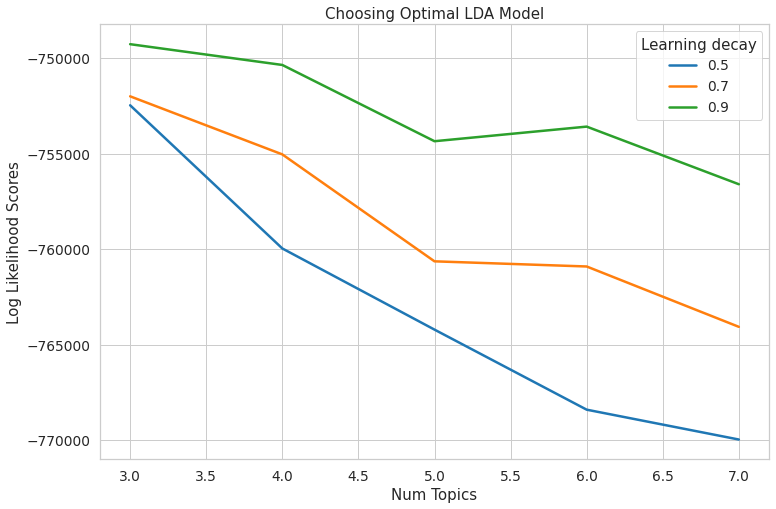

In [ ]:
# Get Log Likelihoods from Grid Search Output
n_topics = [3, 4, 5, 6, 7]
log_likelihoods_5 = [round(model.cv_results_['mean_test_score'][x]) for x in range(0,5)]
log_likelihoods_7 = [round(model.cv_results_['mean_test_score'][x]) for x in range(5,10)]
log_likelihoods_9 = [round(model.cv_results_['mean_test_score'][x]) for x in range(10,15)]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihoods_5, label='0.5')
plt.plot(n_topics, log_likelihoods_7, label='0.7')
plt.plot(n_topics, log_likelihoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
print_topics(best_lda_model, count_vect, n_top_words=30)

Topic #0:
good chicken rice food place beef tea fried meat spicy try like soup korean delicious bbq love thai pork really dishes best ordered favorite sauce great roll pho noodles ve
Topic #1:
food place great good service time vegas just like really nice best restaurant friendly staff definitely amazing don come love ve bar people drinks night order experience got pizza little
Topic #2:
good ordered just like got came order cheese didn time steak food sauce bread meal fries service really chicken ve asked said table restaurant salad did delicious cooked dish went


In [ ]:
pickle.dump(best_lda_model, open('./lda_model_02112020.pk', 'wb'))

### Load pre-saved model

In [ ]:
# Load pre-saved model
best_lda_model = pickle.load(open('./lda_model_02112020.pk', 'rb'))
print(best_lda_model)
print("Model Log likehood: ", best_lda_model.score(doc_term_matrix))
print("Model perplexity:   ", best_lda_model.perplexity(doc_term_matrix))

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.9,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
Model Log likehood:  -3552870.907237554
Model perplexity:    2092.7258155646396


### Analyze results

In [ ]:
import os

LDAvis_data_filepath = os.path.join('./ldavis_prepared_09112020')
LDAvis_prepared = sklearn_lda.prepare(best_lda_model, doc_term_matrix, count_vect)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_09112020' + '.html')

https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

### Assign topics to each review

In [ ]:
topic_values = best_lda_model.transform(doc_term_matrix)
print(topic_values.shape)

reviews_df_trunc['topic'] = topic_values.argmax(axis=1)

reviews_df_trunc.to_csv("./reviews_LDA.csv")

(10000, 3)


### Doing analysis on the topics

In [ ]:
print_topics(best_lda_model, count_vect, n_top_words=20)

pd.set_option('display.max_colwidth', None)

topic = 1

'''
Topic 0: Food                   (1318)
  - KW: Chicken, rice, beef, noodles, tea, fried
  - Examples:
    - The best crab rangoon And the food was delicious. It was the best Thai food to get delivery from.
    - What a find ! Great food. We had the veggie combo and the meat combo. Genuine Ethiopian food. Highly recommended.
    - with that pricw. the foos is horrible. i ordered a sushi platter.and the taste is soso,the eel sushi is highly fishy
Topic 1: Place, Staff           (6223)
  - KW: Place, friendly, staff, experience, restaurant
  - Examples:
    - Very unique ambiance and interesting back story. It was really crowded and loud when I was there so it wasn't very conducive for studying. Other than that, it was nice.
    - Excellent food, atmosphere and attention to detail. Thank you Carmen (server) for t he great suggestions!\nBeautiful decor and upscale music and feel.
    - It's 108 so we stopped for a beer.. The allure of the place is the live music. We came before that. Wasn't impressed..	
Topic 2: Service, Efficiency    (2459)
  - KW: Order, service, came, time
  - Examples:
    - Waited over 30 minutes to be seated. Ordered steaks. Not very good. Tough and chewy. Salad and bread were the best part of the meal. Will not be back.
    - I literally waited 20 minuets for sake and spice chicken. They said pull up to wait no one was behind me. Once I had a bite my chicken patty was cold. Smh
    - The Acai bowls, smoothies and panini are quite yummy but unless you have 20-25 minutes to wait this may not be the best option. \nThe best way around the wait is to order before, online.	
'''

# Try to analyze what each topic is talking about, filtering for reviews less than 200 words
# for succinct topics, long reviews tend to go on a tangent to cover a lot of things
mask = (reviews_df_trunc['topic'] == topic) & (reviews_df_trunc['text'].str.len() <= 200)
topic_df = reviews_df_trunc.loc[mask]
print()
print(f'Topic {topic}: {topic_df.shape}')
topic_df[['text', 'stars']][100:150]

Topic #0:
good chicken rice food place beef tea fried meat spicy try like soup korean delicious bbq love thai pork really
Topic #1:
food place great good service time vegas just like really nice best restaurant friendly staff definitely amazing don come love
Topic #2:
good ordered just like got came order cheese didn time steak food sauce bread meal fries service really chicken ve

Topic 1: (1558, 9)


,text,stars
702,"loved my burrito, but these girls next to me hated their tacos, at pink taco? lol i guess you have to know what to order and not expect authentic Mexican food :]",4.0
703,Delicious food and wonderful staff. Had the salmon burger and shrimp sliders (yum). Great fries. Dina and VIda were terrific servers.,5.0
707,This is one of the best New York style pizza I ever had and the guys are very nice. I definitely will come back to this place.,5.0
714,My first stop when I hit the city. It's like eating at grandmas kitchen table.great customer service always.never disappointed!live this place.,5.0
721,"Dimsum - very good\nIndian - excellent\nService and ambiance - very good\nGreat dining experience.\nA must with every Vegas visit.\nThe Asst Manager- F&B, Mr. Tony Dochev is awesome.",5.0
725,"Sunday brunch. Good service, moderate prices, and great food. Tried the steak and egg tacos, monkey bread (a must if you have a sweet tooth) with a bloody mary.",5.0
731,Great restaurant that not many people know about. Worth the drive. Cool owner with great prices. Can't beat it. As good as roscoes in LA.,5.0
739,Not sure why all the bad reviews. I've been ordering pizza from this location for a decade and have never had a problem.,5.0
744,Ok.....service is crazy slow even @ 2:30 they had two waiters for the entire place....One of the rolls we got tasted like it was canned tuna. House salad was good though....,2.0
766,great pit stop,5.0


In [ ]:
# Review how each document contributes to each topic

topic_names = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
doc_names = ["Doc" + str(i) for i in range(len(reviews_df_trunc))]

df_document_topic = pd.DataFrame(np.round(topic_values, 2), columns=topic_names, index=doc_names)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# These two should match
display(df_document_topic.head())
display(reviews_df_trunc.head())

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.01,0.01,0.97,2
Doc1,0.09,0.87,0.04,1
Doc2,0.06,0.92,0.02,1
Doc3,0.00,0.35,0.65,2
Doc4,0.01,0.94,0.06,1


,review_id,business_id,stars,useful,funny,cool,text,text_processed,topic
0,i6g_oA9Yf9Y31qt0wibXpw,5JxlZaqCnk1MnbgRirs40Q,1.0,0.0,0.0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" glop;\n\nMumbly, unengaged waiter;\n\nClueless manager, who seeing us with barely nibbled entrees\non plates shoved forward for pickup, thanked us\nperfunctorily for our patronage;\n\nWe're from the Texas Hill Country;\ndown there, we jail critters \nwho serve up grub this bad,\nfor their own protection.\n\nNever, never, NEVER again\n(Back to Yard House for real food)","dismal lukewarm defrosted-tasting ""texmex"" glop;\n\nmumbly unengaged waiter;\n\nclueless manager who seeing us with barely nibbled entrees\non plates shoved forward for pickup thanked us\nperfunctorily for our patronage;\n\nwe're from the texas hill country;\ndown there we jail critters \nwho serve up grub this bad\nfor their own protection\n\nnever never never again\n(back to yard house for real food)",2
1,bVTjZgRNq8ToxzvtiVrqMA,d4qwVw4PcN-_2mK2o1Ro1g,1.0,0.0,0.0,0.0,"10pm on a super bowl Sunday and they're already closed?? Weak, no wonder the hard Rock is dying off...",10pm on a super bowl sunday and they're already closed weak no wonder the hard rock is dying off,1
2,TeX0eOIeZb_wpo86rCedXQ,d4qwVw4PcN-_2mK2o1Ro1g,5.0,0.0,0.0,0.0,Holy heck this place is amazing. I love their chicken tacos they're by far my favorite. Great customer service and all round awesome experience.,holy heck this place is amazing i love their chicken tacos they're by far my favorite great customer service and all round awesome experience,1
3,XvLG7ReC8JZmBltOLJzfcA,XZbuPXdyA0ZtTu3AzqtQhg,4.0,0.0,1.0,0.0,"As the previous person posted, what more can really be said about this restaurant. I just came back from Vegas this morning and a truly truly horrible experience. I only went out there for a concert and the concert and this restaurant were the best parts of my trip. I went in here accidentally, meaning, i had no clue it was Bobby Flay's restaurant. I was hungry and Caesars Palace was a across from where I was staying and all the restaurants in my hotel were packed and had lines, I walked right in with no waiting. (I will assume now that since its Bobby's place this place can get crowded so I feel the need to note this was a Sunday about 11:45am) Once inside Caesars Palace, I went to the first restaurant I saw, which was this one. I realized mid-meal it was his restaurant when the waiter at the table next to me was explaining to the recently seated couple that ""Mr Flay likes a little spice so beware all of our dishes have a little kick"" (they were an older couple). I know i'm slow after he said that, that's when i realized why they had his cookbooks in the front. :) (but like i said had a horrible trip so i wasn't even looking for things like this) anyway onto the food.\n\nFOOD: fantastic. I went on sunday and i got the eggs and aged striploin tortilla (fancy name for steak and eggs) and it was yummy. It came with all this spices of sorts (well they werent spices). I am not really sure how to describe it, more like the consistency of salsa's but they werent salsa's, at any rate it was really good mix with the eggs. I had a side of home fries which were a little burnt but oh well. The steak was very good, very flavored, moist and tender. Overall very good. Had a cappuccino too, also very good. I wish i had tried the crabcake's but i knew i wasnt going to eat all that. waiters were awesome, just the right amount of attentiveness. (I personally hate when waiters/waitresses, come back every 5 minutes, is everything ok is everything ok...sheesh can i enjoy my meal?) \n\nAnyway like i said, i had a horrible experience in vegas and this and the concert i went to see were the best parts about my trip, very glad i blessed up on this place.\n\nP.S. Take notice, i have never eaten in a celebrity chef's restaurant and noticed that there were no salt and pepper shakers on any table. ha just a fun tidbit, i thought t

In [ ]:
pd.set_option('display.max_colwidth', 100)

def retrieve_business_reviews(reviews_df, business_id):
    reviews = reviews_df.loc[reviews_df['business_id'] == business_id]
    return reviews[['business_id', 'stars', 'text', 'topic']]

print("Distribution of predicted topics")
display(reviews_df_trunc.groupby('topic').count())

print("\nRetrieving reviews for a specific business")
display(retrieve_business_reviews(reviews_df_trunc, '5JxlZaqCnk1MnbgRirs40Q'))

print("\n Distribution of reviews")
display(reviews_df_trunc.groupby('business_id').count().sort_values(by='text', ascending=False).head(10))

Distribution of predicted topics


,review_id,business_id,stars,useful,funny,cool,text,text_processed
topic,,,,,,,,
0,1318,1318,1318,1318,1318,1318,1318,1318
1,6223,6223,6223,6223,6223,6223,6223,6223
2,2459,2459,2459,2459,2459,2459,2459,2459



Retrieving reviews for a specific business


,business_id,stars,text,topic
0,5JxlZaqCnk1MnbgRirs40Q,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" glop;\n\nMumbly, unengaged waiter;\n\nClueless mana...",2
2797,5JxlZaqCnk1MnbgRirs40Q,3.0,"The three stars here don't represent a real review. Oh, I had all intentions of writing a revie...",1
3593,5JxlZaqCnk1MnbgRirs40Q,4.0,"I've been here several times, but I never reviewed it before. We went here tonight and had a gr...",2
4933,5JxlZaqCnk1MnbgRirs40Q,2.0,I took my folks here last weekend for dinner on a Saturday night. They were busy but didn't see...,1
6079,5JxlZaqCnk1MnbgRirs40Q,4.0,"Above average in taste & presentation, which is unusual for a casino location. Flavors and sauce...",2
7091,5JxlZaqCnk1MnbgRirs40Q,3.0,I came here on a Friday night just to hang out and kick off the weekend. We were seated at the b...,1
7971,5JxlZaqCnk1MnbgRirs40Q,3.0,we're from san diego so mexican places have tough competition for comparisons. margaritas are g...,1
8351,5JxlZaqCnk1MnbgRirs40Q,3.0,"Above average in taste & presentation, which is unusual for a casino location. Flavors and sauce...",2
8998,5JxlZaqCnk1MnbgRirs40Q,4.0,Don't know why we like this particular Cabo over Palace or Santa Fe locations but we always seem...,1



 Distribution of reviews


,review_id,stars,useful,funny,cool,text,text_processed,topic
business_id,,,,,,,,
rcaPajgKOJC2vo_l3xa42A,304,304,304,304,304,304,304,304
XZbuPXdyA0ZtTu3AzqtQhg,283,283,283,283,283,283,283,283
hihud--QRriCYZw1zZvW4g,187,187,187,187,187,187,187,187
IhNASEZ3XnBHmuuVnWdIwA,139,139,139,139,139,139,139,139
7sb2FYLS2sejZKxRYF9mtg,122,122,122,122,122,122,122,122
Ec9CBmL3285XkeHaNp-bSQ,117,117,117,117,117,117,117,117
eaNenRk_liZBERFFLCXqqQ,116,116,116,116,116,116,116,116
bsrj9_hFAql3dlSf244zpg,112,112,112,112,112,112,112,112
GI-CAiZ_Gg3h21PwrANB4Q,110,110,110,110,110,110,110,110


In [ ]:
'''
- Derive business profile based on reviews, topic and star
- Explore what topic do people review on the most (Place and Staff)
- Explore the avg stars for each topic: Do people review when its bad for that topic?
'''

'''
Create a profile of a given business based on its reviews:
  d4qwVw4PcN-_2mK2o1Ro1g (87)
  rcaPajgKOJC2vo_l3xa42A (304) (Good performance)
  XZbuPXdyA0ZtTu3AzqtQhg (283) (Good performance)
  hihud--QRriCYZw1zZvW4g (187) (Particularly bad service)
  IhNASEZ3XnBHmuuVnWdIwA (139)
  7sb2FYLS2sejZKxRYF9mtg (122)
  Ec9CBmL3285XkeHaNp-bSQ (117)
  eaNenRk_liZBERFFLCXqqQ (116)
  bsrj9_hFAql3dlSf244zpg (112)
'''
def profile_business(business_id):
    reviews = reviews_df_trunc.loc[reviews_df_trunc['business_id'] == business_id]
    reviews = reviews[['business_id', 'stars', 'topic']]

    topic_0_reviews = reviews.loc[reviews['topic'] == 0]
    topic_0_score = sum(list(topic_0_reviews['stars'])) / topic_0_reviews.shape[0] if topic_0_reviews.shape[0] > 0 else 0

    topic_1_reviews = reviews.loc[reviews['topic'] == 1]
    topic_1_score = sum(list(topic_1_reviews['stars'])) / topic_1_reviews.shape[0] if topic_1_reviews.shape[0] > 0 else 0

    topic_2_reviews = reviews.loc[reviews['topic'] == 2]
    topic_2_score = sum(list(topic_2_reviews['stars'])) / topic_2_reviews.shape[0] if topic_2_reviews.shape[0] > 0 else 0

    print('='*63)
    print(f'| Business Profile Scoring ({reviews.shape[0]:3} reviews in total)             |')
    print('='*63)
    print(f'| ID | {business_id}                                 |')
    print('='*63)
    print(f'| Food Quality (Topic 0):         {topic_0_score:.2f} (Based on {topic_0_reviews.shape[0]:3} reviews) |')
    print(f'| Place & Staff (Topic 1):        {topic_1_score:.2f} (Based on {topic_1_reviews.shape[0]:3} reviews) |')
    print(f'| Service & Efficiency (Topic 2): {topic_2_score:.2f} (Based on {topic_2_reviews.shape[0]:3} reviews) |')
    print('='*63)

In [ ]:
business_ids = [
  'rcaPajgKOJC2vo_l3xa42A',
  'XZbuPXdyA0ZtTu3AzqtQhg',
  'hihud--QRriCYZw1zZvW4g',
  'IhNASEZ3XnBHmuuVnWdIwA',
  '7sb2FYLS2sejZKxRYF9mtg',
  'Ec9CBmL3285XkeHaNp-bSQ',
  'eaNenRk_liZBERFFLCXqqQ',
  'bsrj9_hFAql3dlSf244zpg',
  'GI-CAiZ_Gg3h21PwrANB4Q',
  'ItqPtxnayraXSlBS0EMOgg',
  'd4qwVw4PcN-_2mK2o1Ro1g',
]

for id in business_ids:
    profile_business(id)

| Business Profile Scoring (304 reviews in total)             |
| ID | rcaPajgKOJC2vo_l3xa42A                                 |
| Food Quality (Topic 0):         5.00 (Based on   3 reviews) |
| Place & Staff (Topic 1):        4.18 (Based on  73 reviews) |
| Service & Efficiency (Topic 2): 4.07 (Based on 228 reviews) |
| Business Profile Scoring (283 reviews in total)             |
| ID | XZbuPXdyA0ZtTu3AzqtQhg                                 |
| Food Quality (Topic 0):         4.00 (Based on   4 reviews) |
| Place & Staff (Topic 1):        3.93 (Based on  67 reviews) |
| Service & Efficiency (Topic 2): 4.01 (Based on 212 reviews) |
| Business Profile Scoring (187 reviews in total)             |
| ID | hihud--QRriCYZw1zZvW4g                                 |
| Food Quality (Topic 0):         4.35 (Based on  63 reviews) |
| Place & Staff (Topic 1):        4.33 (Based on 114 reviews) |
| Service & Efficiency (Topic 2): 2.70 (Based on  10 reviews) |
| Business Profile Scoring (139 reviews 

In [ ]:
# Explore the avg stars for each topic: Do people review when its bad for that topic?
reviews_df_trunc.head()

reviews_0 = reviews_df_trunc.loc[reviews_df_trunc['topic'] == 0]
reviews_0_score = sum(list(reviews_0['stars'])) / reviews_0.shape[0] if reviews_0.shape[0] > 0 else 0
print(f'Average score for topic 0 reviews: {reviews_0_score:.2f} (Based on {reviews_0.shape[0]} reviews)')

reviews_1 = reviews_df_trunc.loc[reviews_df_trunc['topic'] == 1]
reviews_1_score = sum(list(reviews_1['stars'])) / reviews_1.shape[0] if reviews_1.shape[0] > 0 else 0
print(f'Average score for topic 1 reviews: {reviews_1_score:.2f} (Based on {reviews_1.shape[0]} reviews)')

reviews_2 = reviews_df_trunc.loc[reviews_df_trunc['topic'] == 2]
reviews_2_score = sum(list(reviews_2['stars'])) / reviews_2.shape[0] if reviews_2.shape[0] > 0 else 0
print(f'Average score for topic 1 reviews: {reviews_2_score:.2f} (Based on {reviews_2.shape[0]} reviews)')

# I guess for food, people generally leave reviews if the food is good, not as often if food is bad

Average score for topic 0 reviews: 4.33 (Based on 1318 reviews)
Average score for topic 1 reviews: 3.92 (Based on 6223 reviews)
Average score for topic 1 reviews: 3.38 (Based on 2459 reviews)
